In [1]:
from absa_parser import Dataset

def semeval_get_data(filename):
    data = Dataset(filename)
    print("Num of reviews: " + str(len(data.reviews)))
    print("Num of opinions: " + str(data.get_opinion_count()))
    print(data.tokenized_reviews[0][0])
    print(data.tokenized_reviews[0][0])
    return data

TRAIN_FILENAME = "/media/yallen/My Passport/Datasets/Sentiment/ABSA16/ABSA16_Restaurants_Ru_Train.xml"
TEST_FILENAME = "/media/yallen/My Passport/Datasets/Sentiment/ABSA16/ABSA16_Restaurants_Ru_Test.xml"
train_data = semeval_get_data(TRAIN_FILENAME)
test_data = semeval_get_data(TEST_FILENAME)

Num of reviews: 312
Num of opinions: 4089
[<Word "Добрый" from 0 to 6 with opinion None at 0x7f732985fa20>, <Word "час" from 7 to 10 with opinion None at 0x7f732985f978>, <Word "суток" from 11 to 16 with opinion None at 0x7f732985f9b0>, <Word "." from 16 to 17 with opinion None at 0x7f732985f940>]
[<Word "Добрый" from 0 to 6 with opinion None at 0x7f732985fa20>, <Word "час" from 7 to 10 with opinion None at 0x7f732985f978>, <Word "суток" from 11 to 16 with opinion None at 0x7f732985f9b0>, <Word "." from 16 to 17 with opinion None at 0x7f732985f940>]
Num of reviews: 103
Num of opinions: 1300
[<Word "Очень" from 0 to 5 with opinion None at 0x7f7329bccc50>, <Word "милый" from 6 to 11 with opinion None at 0x7f7329bccc88>, <Word "," from 11 to 12 with opinion None at 0x7f7329bccba8>, <Word "уютный" from 13 to 19 with opinion None at 0x7f7329bccb70>, <Word "ресторанчик" from 20 to 31 with opinion <Opinion 20:31 AMBIENCE#GENERAL 3 at 0x7f7329af2208> at 0x7f7329bccb00>, <Word "со" from 32 to 3

In [2]:
from rnnmorph.predictor import RNNMorphPredictor
from rnnmorph.data_preparation.grammeme_vectorizer import GrammemeVectorizer
from absa_parser import Word

class PosTaggedWord(Word):
    def __init__(self, word, pos, tag, vector):
        Word.__init__(self, word.text, word.begin, word.end)
        self.opinion = word.opinion
        self.pos = pos
        self.tag = tag
        self.vector = vector

    def __repr__(self):
        return '<PosTaggedWord "{word}", {pos}#{tag}, {vector} at {hid}>'.format(
            word = self.text,
            pos = self.pos,
            tag = self.tag,
            vector = self.vector,
            hid = hex(id(self))
        )

def pos_tag_reviews(reviews):
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    predictor = RNNMorphPredictor()
    grammeme_vectorizer = GrammemeVectorizer("gram_output.json")
    pos_tagged_reviews = []
    for review in reviews:
        pos_tagged_reviews.append([])
        for sentence in review:
            words = [word.text for word in sentence]
            forms = predictor.predict_sentence_tags(words)
            pos_tagged_sentence = []
            for word_idx, form in enumerate(forms):
                vector = grammeme_vectorizer.get_vector(form.pos + "#" + form.tag)
                pos_tagged_sentence.append(PosTaggedWord(sentence[word_idx], form.pos, form.tag, vector))
            pos_tagged_reviews[-1].append(pos_tagged_sentence)
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    return pos_tagged_reviews

grammeme_vectorizer = GrammemeVectorizer("gram_output.json")
vocabulary = train_data.get_vocabulary()
train_pos_data = pos_tag_reviews(train_data.tokenized_reviews)
test_pos_data = pos_tag_reviews(test_data.tokenized_reviews)
print(train_pos_data[0][0])

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[<PosTaggedWord "Добрый", ADJ#Case=Acc|Degree=Pos|Gender=Masc|Number=Sing, [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1] at 0x7f72d6f94e80>, <PosTaggedWord "час", NOUN#Case=Nom|Gender=Masc|Number=Sing, [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1] at 0x7f732e2a1e80>, <PosTaggedWord "суток", NOUN#Case=Gen|Number=Plur, [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1] at 0x7f72d6cd5550>, <PosTaggedWord ".", PUNCT#_, [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1] at 0x7f72d6cd5dd8>]


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

def form_text_vectorizer(reviews):
    vectorizer = TfidfVectorizer(ngram_range=(1, 1))
    all_texts = []
    for review in reviews:
        for sentence in review:
            words = [word.text for word in sentence]
            text = " ".join(words)
            all_texts.append(text)
    vectorizer.fit(all_texts)
    return vectorizer

def form_context_samples(reviews, pos_vector_size, context_window):
    text_vectorizer = form_text_vectorizer(reviews)
    all_texts = []
    all_pos_vectors = []
    target = []
    for review in reviews:
        for sentence in review:
            for i, word in enumerate(sentence):
                left_padding = context_window - i
                right_padding = i + 1 + context_window - len(sentence)
                
                begin = i - context_window if left_padding <= 0 else 0
                end = i + 1 + context_window if right_padding <= 0 else len(sentence)
                text = " ".join([word.text for word in sentence[begin:end]])
                if text != '':
                    target.append(int(word.is_colored()))
                    all_texts.append(text)

                psos = [word.vector for word in sentence[begin:end]]
                vectorized_pos = [elem for vector in psos for elem in vector]
                if left_padding > 0:
                    vectorized_pos = [0 for _ in range(left_padding * pos_vector_size)] + vectorized_pos
                if right_padding > 0:
                    vectorized_pos = vectorized_pos + [0 for _ in range(right_padding * pos_vector_size)]
                all_pos_vectors.append(vectorized_pos)
            
    all_pos_vectors = csr_matrix(all_pos_vectors)
    vectorized_texts = text_vectorizer.transform(all_texts)
    
    return hstack([vectorized_texts, all_pos_vectors]), target

X, y = form_context_samples(train_pos_data, grammeme_vectorizer.grammemes_count(), 1)
print(X.shape)
print(sum(y))

(51887, 7646)
4132


In [43]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score

pipe = Pipeline([('clf', LinearSVC())])
param_grid = [{'clf__C': [1, 10, 100, 1000]}]
grid = GridSearchCV(pipe, scoring=make_scorer(roc_auc_score), cv=5, param_grid=param_grid)
grid.fit(X, y)
print(grid.cv_results_['mean_test_score'])

[0.76599408 0.7661763  0.73972641 0.77188669]


In [3]:
FAT_FILE = "/media/yallen/My Passport/Models/russian-big-w2v.txt"

def shrink_w2v(input_filename, output_filename, vocabulary):
    vocabulary_embeddings = dict()
    all_count = 0
    found_count = 0
    words = set(vocabulary.word2index.keys())
    with open(input_filename, "r", encoding='utf-8') as r:
        line = next(r)
        dimension = int(line.strip().split()[1])
        while True:
            try:
                if all_count % 100000 == 0:
                    print(all_count, found_count, len(words))
                if found_count == 6700:
                    break
                line = next(r)
                try:
                    current_word = line.split()[0]
                    if current_word in words:
                        new_embedding = [float(i) for i in line.strip().split()[1:]]
                        vocabulary_embeddings[vocabulary.word2index[current_word]] = new_embedding
                        words.remove(current_word)
                        found_count += 1
                except ValueError:
                    pass
                all_count += 1
            except UnicodeDecodeError:
                pass
            except StopIteration:
                break
        vocabulary_embeddings = {key:value for key, value in vocabulary_embeddings.items() 
                                 if len(value) == dimension}
        with open(output_filename, "w", encoding='utf-8') as w:
            w.write(str(len(vocabulary_embeddings.items())) + " " + str(dimension) + "\n")
            for i, word in enumerate(vocabulary.index2word):
                if i in vocabulary_embeddings:
                    embedding = " ".join([str(j) for j in list(vocabulary_embeddings[i])])
                    w.write(word + " " + embedding + "\n")

shrink_w2v(FAT_FILE, "w2v.txt", vocabulary)

0 0 8578
100000 5628 2950
200000 6219 2359
300000 6449 2129
400000 6543 2035
500000 6615 1963
600000 6652 1926
700000 6682 1896


In [49]:
import gensim
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from random import shuffle

class RemotionRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, rnn_size, gram_vector_size, gram_hidden_size, n_layers=3, 
                 dropout=0.3, bidirectional=True):
        super(RemotionRNN, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.rnn_size = rnn_size
        self.gram_vector_size = gram_vector_size
        self.gram_hidden_size = gram_hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.grammeme_dense = nn.Linear(gram_vector_size, gram_hidden_size)
        self.grammeme_activation = nn.ReLU()
        self.rnn = nn.LSTM(embedding_dim + gram_hidden_size, rnn_size, n_layers, 
                           dropout=dropout, bidirectional=bidirectional)
        self.output = nn.Linear(rnn_size * 2, 1)
        self.sm = nn.Softmax(dim=1)
        

    def forward(self, input_seqs, gram_vectors, hidden=None):
        embedded = self.embedding(input_seqs)
        grammeme = self.grammeme_activation(self.grammeme_dense(gram_vectors))
        rnn_input = torch.cat((embedded, grammeme), dim=2)
        outputs, hidden = self.rnn(rnn_input, hidden)
        predictions = self.sm(self.output(outputs).squeeze(2))
        return predictions

def save_model(model, optimizer, filename):
    model_state_dict = model.state_dict()
    for key in model_state_dict.keys():
        model_state_dict[key] = model_state_dict[key].cpu()
    torch.save({
        'model': model_state_dict,
        'input_size': model.input_size,
        'n_layers': model.n_layers,
        'rnn_size': model.rnn_size,
        'dropout': model.dropout,
        'embedding_dim': model.embedding_dim,
        'gram_vector_size': model.gram_vector_size,
        'gram_hidden_size': model.gram_hidden_size,
        'bidirectional': model.bidirectional,
        'optimizer': optimizer.state_dict()
    }, filename)


def load_model(model_filename, use_cuda):
    state_dict = torch.load(model_filename)
    model = RemotionRNN(
        input_size=state_dict['input_size'], 
        embedding_dim=state_dict['embedding_dim'], 
        rnn_size=state_dict['rnn_size'], 
        gram_vector_size=state_dict['gram_vector_size'], 
        gram_hidden_size=state_dict['gram_hidden_size'], 
        n_layers=state_dict['n_layers'], 
        dropout=state_dict['dropout']
    )
    model.load_state_dict(state_dict['model'])
    model.embedding.weight.requires_grad = False
    model = model.cuda() if use_cuda else model

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    optimizer.load_state_dict(state_dict['optimizer'])

    return model, optimizer

def get_embeddings(vocabulary, embeddings_filename, binary=False):
    embeddings = torch.div(torch.randn(vocabulary.size(), 500), 100)
    w2v = gensim.models.KeyedVectors.load_word2vec_format(embeddings_filename, binary=binary)
    unknown_words_count = 0
    for i, word in enumerate(vocabulary.index2word):
        if word in w2v:
            embeddings[i] = torch.FloatTensor(w2v[word])
        else:
            unknown_words_count += 1
    embeddings[0] = torch.zeros((500,))
    print("Unknown words in {filename}: {count}".format(count=unknown_words_count, filename=embeddings_filename))
    return embeddings

def get_batches(data, vocabulary, gram_vector_size, batch_size, max_length):
    text_batch = []
    gram_batch = []
    y = []
    for review in data:
        indices = []
        gram_vectors = []
        target = []
        for sentence in review:
            text = " ".join([word.text for word in sentence])
            indices += vocabulary.get_indices(text)
            gram_vectors += [word.vector for word in sentence]
            target += [word.is_colored() for word in sentence]

        indices = vocabulary.pad_indices(indices, max_length)[:max_length]
        for _ in range(max_length-len(gram_vectors)):
            gram_vectors.append([0 for _ in range(gram_vector_size)])
        gram_vectors = gram_vectors[:max_length]
        target += [0 for _ in range(max_length-len(target))]
        target = target[:max_length]
        
        text_batch.append(indices)
        gram_batch.append(gram_vectors)
        y.append(target)
            
        if len(text_batch) == batch_size:
            text_var = Variable(torch.LongTensor(text_batch), requires_grad=False)
            gram_var = Variable(torch.FloatTensor(gram_batch), requires_grad=False)
            y_var = Variable(torch.FloatTensor(y), requires_grad=False)
            yield text_var, gram_var, y_var
            text_batch = []
            gram_batch = []
            y = []
    if len(text_batch) != 0:
        text_var = Variable(torch.LongTensor(text_batch), requires_grad=False)
        gram_var = Variable(torch.FloatTensor(gram_batch), requires_grad=False)
        y_var = Variable(torch.FloatTensor(y), requires_grad=False)
        yield text_var, gram_var, y_var

def do_epoch(model, criterion, text_batch, gram_batch, y, use_cuda, optimizer=None):
    text_batch = text_batch.cuda() if use_cuda else text_batch
    gram_batch = gram_batch.cuda() if use_cuda else gram_batch
    y = y.cuda() if use_cuda else y
    
    if optimizer is not None:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()
        
    predictions = model.forward(text_batch, gram_batch)
    loss = criterion(predictions, y)
    
    if optimizer is not None:
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
    return loss.data.item(), predictions

def train_model(train_data, vocabulary, gram_vector_size, batch_size=8, max_length=300, epochs=15, 
          embeddings_size=500, rnn_size=32, gram_hidden_size=16, n_layers=3, lr=0.001):
    use_cuda = torch.cuda.is_available()
    
    model = RemotionRNN(vocabulary.size(), embeddings_size, rnn_size, gram_vector_size, 
                        gram_hidden_size, n_layers=n_layers)
    embeddings = get_embeddings(vocabulary, "w2v.txt")
    model.embedding.weight = nn.Parameter(embeddings, requires_grad=False)
    model = model.cuda() if use_cuda else model
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = torch.nn.BCELoss(size_average=False)
    
    val_size = 0.2
    train_size = 1 - val_size
    border = int(len(train_data)*train_size)
    shuffle(train_data)
    train_data, val_data = train_data[:border], train_data[border:]

    for epoch in range(epochs):
        train_loss = 0
        train_count = 0
        train_batches = get_batches(train_data, vocabulary, gram_vector_size, batch_size, max_length)
        for text_batch, gram_batch, y in train_batches:
            loss, _ = do_epoch(model, criterion, text_batch, gram_batch, y, use_cuda, optimizer)
            train_loss += loss
            train_count += 1
        
        val_loss = 0
        val_count = 0
        all_y = []
        all_pred = []
        val_batches = get_batches(val_data, vocabulary, gram_vector_size, batch_size, max_length)
        for text_batch, gram_batch, y in val_batches:
            model.eval()
            loss, predictions = do_epoch(model, criterion, text_batch, gram_batch, y, use_cuda)
            val_loss += loss
            val_count += 1
            
            lengths = []
            for i in range(text_batch.size(0)):
                lengths.append(sum([int(elem != 0) for elem in text_batch[i].data]))
            for i in range(y.size(0)):
                all_y += list(y.data[i])[:lengths[i]]
            for i in range(y.size(0)):
                all_pred += list(predictions.data[i])[:lengths[i]]
        print("Train loss: {train_loss}, val loss: {val_loss}, roc auc: {roc_auc}".format(
            train_loss = train_loss/train_count,
            val_loss = val_loss/val_count,
            roc_auc = roc_auc_score(all_y, all_pred)
        ))
        save_model(model, optimizer, "model.pt")
        load_model("model.pt", use_cuda)
    return model

model = train_model(train_pos_data, 
                    vocabulary, 
                    grammeme_vectorizer.grammemes_count(), 
                    epochs=9, 
                    rnn_size=32, 
                    gram_hidden_size=16,
                    n_layers=3)

Unknown words in w2v.txt: 1879
Train loss: 569.4254587888718, val loss: 572.0569801330566, roc auc: 0.6415082154314087
Train loss: 507.7947180867195, val loss: 502.1954803466797, roc auc: 0.8367997277577179
Train loss: 430.5732264518738, val loss: 428.17279052734375, roc auc: 0.9303619713143426
Train loss: 391.2451772093773, val loss: 411.8207473754883, roc auc: 0.9441735481303531
Train loss: 381.62620705366135, val loss: 407.9316749572754, roc auc: 0.9480433680593057
Train loss: 376.3411095738411, val loss: 405.2206115722656, roc auc: 0.9499169797258311
Train loss: 372.0735237002373, val loss: 403.8201675415039, roc auc: 0.9514273016781138
Train loss: 370.461202442646, val loss: 402.93689346313477, roc auc: 0.9519497966939784
Train loss: 367.90723621845245, val loss: 402.99516677856445, roc auc: 0.9529671781669085


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
No handles with labels found to put in legend.


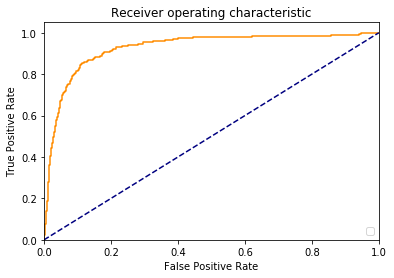

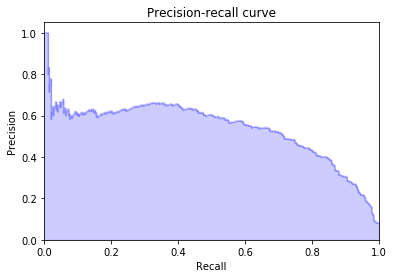

Threshold:  0.091839045


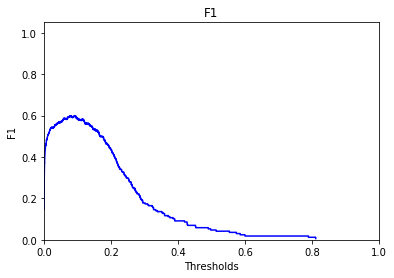

0.5403936947626262
Test loss: 897.3624877929688, roc auc: 0.9261289216748435, f1: 0.5972602739726027, recall: 0.6687116564417178


In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, recall_score

def plot_roc_auc(all_y, all_pred):
    fpr, tpr, _ = roc_curve(all_y, all_pred)
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall(all_y, all_pred):
    precision, recall, thresholds = precision_recall_curve(all_y, all_pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.title('Precision-recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    
    f1 = [2*p*r/(p+r) if p != 0 and r != 0 else 0.0 for p, r in zip(precision, recall)][:len(thresholds)]
    print("Threshold: ", thresholds[np.argmax(f1)])
    plt.step(thresholds, f1, color='b', where='post')
    plt.title('F1')
    plt.xlabel('Thresholds')
    plt.ylabel('F1')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

    return float(thresholds[np.argmax(f1)])

def test_model(model, test_data, vocabulary, gram_vector_size, batch_size=128, max_length=40):
    use_cuda = torch.cuda.is_available()
    criterion = torch.nn.BCELoss(size_average=False)
    test_loss = 0
    test_count = 0
    all_y = []
    all_pred = []
    f1s = []
    test_batches = get_batches(test_data, vocabulary, gram_vector_size, batch_size, max_length)
    for text_batch, gram_batch, y in test_batches:
        model.eval()
        loss, predictions = do_epoch(model, criterion, text_batch, gram_batch, y, use_cuda)
        test_loss += loss
        test_count += 1

        lengths = []
        for i in range(text_batch.size(0)):
            lengths.append(sum([int(elem != 0) for elem in text_batch[i].data]))
        for i in range(y.size(0)):
            review_y = list(y.data[i])[:lengths[i]]
            review_pred = list(predictions.data[i])[:lengths[i]]
            f1s.append(f1_score(review_y, [int(e > 0.0894) for e in review_pred]))
            all_y += review_y
            all_pred += review_pred
    plot_roc_auc(all_y, all_pred)
    threshold = plot_precision_recall(all_y, all_pred)
    all_pred_round = [int(e > threshold) for e in all_pred]
    print(sum(f1s)/len(f1s))
    print("Test loss: {test_loss}, roc auc: {roc_auc}, f1: {f1}, recall: {recall}".format(
        test_loss = test_loss/test_count,
        roc_auc = roc_auc_score(all_y, all_pred),
        f1 = f1_score(all_y, all_pred_round),
        recall = recall_score(all_y, all_pred_round)
    ))
    
test_model(model, test_pos_data, vocabulary, grammeme_vectorizer.grammemes_count())